# Восстановление золота из руды

Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используем данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Подготовка данных

In [ ]:
# !pip install tabulate

In [ ]:
# Importing libraries
import statistics
from tabulate import tabulate
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.linear_model import (
    ElasticNetCV,
    LinearRegression,
    Ridge,
)
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

plt.style.use('dark_background')
pd.set_option('display.max_rows', 100)
cm = sns.dark_palette("purple", as_cmap=True)

In [ ]:
# Variable for fixing randomness
RANDOM_STATE = 42

In [ ]:
# Save data
try:
  gold_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
  gold_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
  gold_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
  gold_train = pd.read_csv('/content/gold_recovery_train_new.csv')
  gold_test = pd.read_csv('/content/gold_recovery_test_new.csv')
  gold_full = pd.read_csv('/content/gold_recovery_full_new.csv')

In [ ]:
def out_g(text):
    '''Function for printing colored text.

    Args:
    text (str): The text to be printed in green color.

    Returns:
    None
    '''
    print(f"\033[32m\033[2m {text}\033[0m")

In [ ]:
def init_inspect(data: pd.DataFrame):
    '''Function for displaying initial data information.

    - Checks the data type, and if it's of type TextFileReader,
      reads it into a DataFrame.
    - Creates a variable 'cols' for later output of features using tabulate.

    Displays:
    - The first 5 rows of data
    - Data types of the first 20 features
    - Data size
    - In tabular form, the 20 largest values:
      - Sorted by missing value proportions
      - Number of missing values per feature
      - Number of unique values per column
    - The total number of complete duplicates in the entire dataset

    Args:
    data (pd.DataFrame or TextFileReader): The data to be analyzed. If the data type is TextFileReader, it will be
                                          read into a DataFrame.

    Returns:
    None
    '''

    # Attempt to work with a DataFrame
    try:

        # If data is a TextFileReader object,
        # read the data into a DataFrame
        if isinstance(data, pd.io.parsers.TextFileReader):
            data = data.read()

        cols = {'Columns': data.columns}

        # Display the first rows of the DataFrame
        out_g(f'Data:')
        display(data.head())
        print()

        # Display statistical metrics
        display(data.describe())

        # Display data types of the first 20 features
        out_g('Type of features:\n')
        display(data.dtypes.head())
        print()

        # Display the length of the DataFrame
        print(out_g('Length:\n'), data.shape)
        print()

        # Use tabulate to create a table of missing value percentages for features
        out_g('Share of missing values:\n')
        print(tabulate(pd.DataFrame(cols | {'Missing values': data.isna().mean().values})
                                .sort_values(by='Missing values', ascending=False)
                                .head(20), headers='keys', tablefmt='github',
                                showindex=False, numalign="center", stralign='center',
                                colalign=("left", "left")))
        print()

        # Use tabulate to create a table of total missing values for features
        out_g('Total number of missing values: \n')
        print(tabulate(pd.DataFrame(cols | {'Missing values': data.isna().sum().values})
                                .sort_values(by='Missing values', ascending=False)
                                .head(20), headers='keys', tablefmt='github',
                                showindex=False, numalign="center", stralign='center',
                                colalign=("left", "left")))
        print()

        out_g('Unique values for each column:\n')

        # Use tabulate to create a table of the number of unique values in each column
        print(tabulate(pd.DataFrame(cols | {'Unique values': data.nunique().values})
                                      .head(20), headers='keys', tablefmt='github',
                                showindex=False, numalign="center", stralign='center',
                                colalign=("left", "left")))
        print()

        # Check for duplicates
        out_g(f'Number of complete duplicates: {data.duplicated().sum()}')

    except:
        print("\033[31m\033[2m🚨 ALARM 🚨\n\n Invalid argument. Expected pd.DataFrame or TextFileReader.\033[0m")


In [ ]:
init_inspect(gold_train)

 Data:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


 Type of signs:



date                             object
final.output.concentrate_ag     float64
final.output.concentrate_pb     float64
final.output.concentrate_sol    float64
final.output.concentrate_au     float64
dtype: object


 Length:

None (14149, 87)

 Share of passes:

| Columns                                  | Missing values   |
|------------------------------------------|------------------|
| secondary_cleaner.output.tail_sol        | 0.113436         |
| rougher.state.floatbank10_e_air          | 0.0308149        |
| rougher.input.floatbank11_xanthate       | 0.0302495        |
| primary_cleaner.output.concentrate_sol   | 0.0202134        |
| secondary_cleaner.state.floatbank2_a_air | 0.0153368        |
| final.output.concentrate_sol             | 0.0149127        |
| rougher.input.feed_size                  | 0.0101774        |
| primary_cleaner.input.xanthate           | 0.00706764       |
| rougher.input.feed_pb                    | 0.00706764       |
| final.output.tail_pb                     | 0.00706764       |
| primary_cleaner.output.concentrate_pb    | 0.00607817       |
| rougher.input.feed_sol                   | 0.00551276       |
| primary_cleaner.output.tail_sol          | 0.00325111 

Наблюдаем большое количество пропусков

In [ ]:
init_inspect(gold_test)

 Data:


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


 Type of signs:



date                                 object
primary_cleaner.input.sulfate       float64
primary_cleaner.input.depressant    float64
primary_cleaner.input.feed_size     float64
primary_cleaner.input.xanthate      float64
dtype: object


 Length:

None (5290, 53)

 Share of passes:

| Columns                                    | Missing values   |
|--------------------------------------------|------------------|
| rougher.input.floatbank11_xanthate         | 0.0047259        |
| rougher.input.feed_sol                     | 0.00396975       |
| secondary_cleaner.state.floatbank3_a_air   | 0.00170132       |
| rougher.input.floatbank11_sulfate          | 0.00151229       |
| primary_cleaner.input.depressant           | 0.00094518       |
| rougher.input.floatbank10_sulfate          | 0.00094518       |
| primary_cleaner.input.xanthate             | 0.000756144      |
| primary_cleaner.input.sulfate              | 0.000756144      |
| rougher.input.feed_rate                    | 0.000567108      |
| secondary_cleaner.state.floatbank2_a_air   | 0.000567108      |
| secondary_cleaner.state.floatbank2_b_air   | 0.000378072      |
| rougher.input.feed_size                    | 0.000189036      |
| secondary_cleaner.state.flo

Аналогичная ситуация с тестовой выборкой

In [ ]:
init_inspect(gold_full)

 Data:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


 Type of signs:



date                             object
final.output.concentrate_ag     float64
final.output.concentrate_pb     float64
final.output.concentrate_sol    float64
final.output.concentrate_au     float64
dtype: object


 Length:

None (19439, 87)

 Share of passes:

| Columns                                  | Missing values   |
|------------------------------------------|------------------|
| secondary_cleaner.output.tail_sol        | 0.0899223        |
| rougher.input.floatbank11_xanthate       | 0.0233037        |
| rougher.state.floatbank10_e_air          | 0.0224291        |
| primary_cleaner.output.concentrate_sol   | 0.0190339        |
| secondary_cleaner.state.floatbank2_a_air | 0.0113175        |
| final.output.concentrate_sol             | 0.0108545        |
| rougher.input.feed_size                  | 0.00745923       |
| primary_cleaner.output.concentrate_pb    | 0.00596739       |
| primary_cleaner.input.xanthate           | 0.00535007       |
| final.output.tail_pb                     | 0.00519574       |
| rougher.input.feed_pb                    | 0.0051443        |
| rougher.input.feed_sol                   | 0.00509285       |
| primary_cleaner.output.tail_sol          | 0.00318946 

In [ ]:
# calculation of the percentage of losses after deleting all the omissions
def percent_loss(data):
  return round((1 - data.dropna().shape[0] / data.shape[0]) * 100, 2)

In [ ]:
# percentage of training sample losses
percent_loss(gold_train)

22.14

In [ ]:
# percentage of test sample losses
percent_loss(gold_test)

1.15

In [ ]:
# percentage of full dataset losses
percent_loss(gold_full)

17.21

Большое количество пропусков, видим также, что медиана и среднее не сильно отличаются по признакам, также стандартное отклонение достаточно маленькое, можем сделать вывод, что для заполнения пропусков нам подойдет метод ближайших соседей

---

Признак date имеет формат object, передем его в формат DateTime и сделаем индексом всех выборок для удобства манипулирования данными

In [ ]:
def process_dates(*dataframes, col: str):
    '''Function for converting date columns to datetime format and setting them as the index.

    Args:
        dataframes (tuple): A variable-length argument list of DataFrames to process.
        col (str): The name of the date column to be converted.

    Returns:
        list: A list of new DataFrames with the date column converted to
              datetime format and set as the index.

    Raises:
        TypeError: If any of the input arguments is not a DataFrame.

    Example:
        df1, df2 = process_dates(df1, df2, col='date_column')
    '''
    try:
        # Create copies of the passed dataframes
        dataframes_new = [dataframe.copy() for dataframe in dataframes]

        # Convert the 'col' column to datetime format
        for data in dataframes_new:
            if not isinstance(data, pd.DataFrame):
                raise TypeError(f'{data} is not a DataFrame')

            data[col] = pd.to_datetime(data[col], format='%Y-%m-%d %H:%M:%S')

            # Set the 'col' column as the index
            data.set_index(col, inplace=True)

        return dataframes_new

    except Exception as e:
        print(f'\033[31m\033[2m🚨 Error: {e}\033[0m')
        return None


In [ ]:
# Creating new modified data
df_train, df_test, df_full = process_dates(gold_train, gold_test, gold_full, col='date')

In [ ]:
# Overwriting check
df_full.head(1)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15,6.055403,9.889648,5.507324,42.19202,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.84198


In [ ]:
# Looking at the main dataset
gold_full.head(1)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.19202,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.84198


Все отлично

---

Проверим, что эффективность обогащения на этапе флотации рассчитана верно.

Нам нужно смоделировать процесс восстановления золота из золотосодержащей  руды.   
Эффективность обогащения рассчитываем по формуле:   
  
Recovery = (С * (F - T) / F * (С - T)) * 100.  
  
где:   
+ C — доля золота в концентрате после флотации/очистки;  
+ F — доля золота в сырье/концентрате до флотации/очистки;  
+ T — доля золота в отвальных хвостах после флотации/очистки.  

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах.  
Причём важен не только финальный продукт, но и черновой концентрат.  

In [ ]:
# For convenience, we will output the columns of the flotation stage
rougher_output_train = df_train.filter(regex='^rougher.output')
rougher_output_train.columns.unique()

Index(['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
       'rougher.output.concentrate_sol', 'rougher.output.concentrate_au',
       'rougher.output.recovery', 'rougher.output.tail_ag',
       'rougher.output.tail_pb', 'rougher.output.tail_sol',
       'rougher.output.tail_au'],
      dtype='object')

In [ ]:
# Calculation of enrichment efficiency
def recovery(C, F, T):
  recovery_value = ((C * (F - T))/ (F * (C - T)) )* 100
  return recovery_value

# Variables required to calculate the enrichment efficiency at the flotation stage
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

In [ ]:
# Omissions in necessary attributes
print(C.isna().mean())
print(F.isna().mean())
print(T.isna().mean())

0.0
0.0
0.0


In [ ]:
# Calculation of enrichment at the flotation stage
recovery_rought = recovery(C, F, T)
recovery_rought

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Length: 14149, dtype: float64

In [ ]:
# Data that is completely duplicated
df_train['rougher.output.recovery'][df_train['rougher.output.recovery'] == recovery_rought]

date
2016-01-15 00:00:00    87.107763
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
2016-01-15 07:00:00    87.668336
2016-01-15 12:00:00    89.299981
                         ...    
2018-08-18 03:59:59    87.684717
2018-08-18 04:59:59    90.677361
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 09:59:59    89.858126
Name: rougher.output.recovery, Length: 6712, dtype: float64

Полных совпадений мы имеем 47%

In [ ]:
print(f'Средняя абсолютная ошибка: \
   {mean_absolute_error(df_train["rougher.output.recovery"], recovery_rought)}')

Средняя абсолютная ошибка: 9.73512347450521e-15


Ошибка не сильно большая, можем сделать вывод, что расчет изначально был произведен верно

---

Изучим признаки, которые отсутсвуют в тестовой выборке

In [ ]:
# Difference in features between test and training samples
missing_cols = set(df_train.columns).difference(set(df_test.columns))
missing_cols

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [ ]:
out_g(f'Количество признаков в train: {df_train.columns.nunique()}\n')
out_g(f'Количество признаков в test: {df_test.columns.nunique()}\n')
out_g(f'Признаков отсутствующих в train: {len(missing_cols)}')

 Количество признаков в train: 86

 Количество признаков в test: 52

 Признаков отсутствующих в train: 34


Видим, что в тестовой выборке отсутсвуют:

+ финальные концентрации металлов продукта и финальные хвосты

+ эффективность обогащения финального продукта

+ концентрации металлов после первичной очистки и их хвосты

+ на этапе флотации расчетные характеристики соотношения золота к свинцу

+ расчетные характеристики подачи сульфата в золото на флотационной установоке 10 и 11

+ содержание концентрата металлов в продукте после этапа флотации

+ эффективность обогащения продукта после флотации

+ концентрация металлов продукта после флотации

+ хвосты после вторичной очистки

Все признаки относятся к продукту на различных этапах, 4 из них относятся к признакам характеристик и 2 к оценке обогащения продукта

---


Необходимо разобраться с пропусками в данных и целевыми признаками в тестовых данных, будем использовать KNNImputer так как для интерполяцции, слишком много имеем пропущенных значений

In [ ]:
def impute_knn(data: pd.DataFrame, n_neighbors: int):
    '''
    Impute missing values using the K-Nearest Neighbors (KNN) imputation method.

    Args:
        data (pd.DataFrame): The DataFrame containing missing values to be imputed.
        n_neighbors (int): The number of nearest neighbors to consider during imputation.

    Returns:
        pd.DataFrame: A new DataFrame with missing values imputed using KNN imputation.

    Example:
        imputed_data = impute_knn(data, n_neighbors=5)
    '''

    imputer = KNNImputer(n_neighbors=n_neighbors)

    df_imputed = pd.DataFrame(imputer.fit_transform(data),
                              columns=data.columns, index=data.index)
    return df_imputed


In [ ]:
# Adding columns final.output.recovery and rougher.output.recovery
df_test = df_test.merge(df_full[['final.output.recovery',
                                 'rougher.output.recovery']],
                        left_index=True, right_index=True, how='left')

# Filling in the gaps in the training and test sample
df_train = impute_knn(df_train, 5)
df_test = impute_knn(df_test, 5)

print(df_train.isna().mean().sort_values(ascending=False).head())
print(df_test.isna().mean().sort_values(ascending=False).head())

final.output.concentrate_ag          0.0
rougher.state.floatbank10_b_air      0.0
rougher.state.floatbank10_f_air      0.0
rougher.state.floatbank10_e_level    0.0
rougher.state.floatbank10_e_air      0.0
dtype: float64
primary_cleaner.input.sulfate               0.0
secondary_cleaner.state.floatbank3_b_air    0.0
rougher.state.floatbank10_d_level           0.0
rougher.state.floatbank10_e_air             0.0
rougher.state.floatbank10_e_level           0.0
dtype: float64


In [ ]:
df_test[['final.output.recovery', 'rougher.output.recovery']].head()

,final.output.recovery,rougher.output.recovery
date,,
2016-09-01 00:59:59,70.273583,89.993421
2016-09-01 01:59:59,68.910432,88.089657
2016-09-01 02:59:59,68.143213,88.412756
2016-09-01 03:59:59,67.776393,87.360133
2016-09-01 04:59:59,61.467078,83.236367


Все снова отлично, пропуски заполнены, целевые признаки в выборки добавлены

## Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [ ]:
# For convenience, we will output the columns of the stages
df_train.filter(regex='concentrate_au$').columns.unique()

Index(['final.output.concentrate_au', 'primary_cleaner.output.concentrate_au',
       'rougher.output.concentrate_au'],
      dtype='object')

In [ ]:
out_g('Концентрация металлов по этапам обработки:')

# Creating a dict with data
data = {
    'Этап': ['Исходное сырье', 'После флотации', 'После первичной очистки', 'После вторичной очистки'],
    'Серебро': [
        df_train['rougher.input.feed_ag'].mean(),
        df_train['rougher.output.concentrate_ag'].mean(),
        df_train['primary_cleaner.output.concentrate_ag'].mean(),
        df_train['final.output.concentrate_ag'].mean()
    ],
    'Свинец': [
        df_train['rougher.input.feed_pb'].mean(),
        df_train['rougher.output.concentrate_pb'].mean(),
        df_train['primary_cleaner.output.concentrate_pb'].mean(),
        df_train['final.output.concentrate_pb'].mean()
    ],
    'Золото': [
        df_train['rougher.input.feed_au'].mean(),
        df_train['rougher.output.concentrate_au'].mean(),
        df_train['primary_cleaner.output.concentrate_au'].mean(),
        df_train['final.output.concentrate_au'].mean()
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Output DataFrame
df.style.background_gradient(cmap=cm)

 Концентрация металлов по этапам обработки:


,Этап,Серебро,Свинец,Золото
0,Исходное сырье,8.579195,3.518402,7.866577
1,После флотации,11.775812,7.664555,19.439958
2,После первичной очистки,8.200916,9.579227,32.386836
3,После вторичной очистки,5.141966,10.132968,44.003792


Как мы видим, концентрация серебра уменьшается к финальному продукту, концентрация свинца увеличивается примерно на 288%, концентрация золота больше изначального на 460% в конечном продукте

---

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

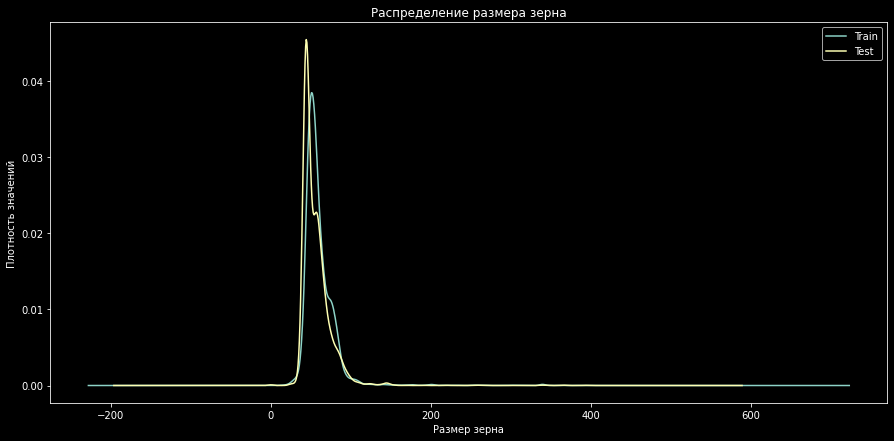

In [ ]:
# graph of the density distribution of the size of pellets of raw materials
plt.figure(figsize=(15, 7))

# Plotting a density graph for a training sample
df_train['rougher.input.feed_size'].plot(kind='kde', label='Train')

# Plotting the density graph for the test sample
df_test['rougher.input.feed_size'].plot(kind='kde', label='Test')

# Adding axis title and captions
plt.title('Распределение размера зерна')
plt.xlabel('Размер зерна')
plt.ylabel('Плотность значений')
plt.legend()
plt.show()

Распределения немного отличаются, но основыные объемы расположены примерно одинаково и присутствуют хвосты

---

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [ ]:
# Select of columns with the concentration of substances on the source material
input_cols = df_train.filter(regex='^rougher\.input\.feed_(ag|pb|sol|au)$').columns

# Select of columns with the concentration of substances at the rougher stage
rougher_cols = df_train.filter(regex='rougher\.output\..*concentrate').columns

# Select of columns with the concentration of substances at the primary_cleaner
primary_cleaner_cols = df_train.filter(regex='primary_cleaner\.output\..*concentrate').columns

# Select of columns with the concentration of substances at the final stage
final_cols = df_train.filter(regex='final\.output\..*concentrate').columns

# Calculation of the total concentration of substances at different stages
input_total_concentrate = df_train[input_cols].sum(axis=1)

rougher_total_concentrate = df_train[rougher_cols].sum(axis=1)

primary_cleaner_total_concentrate = df_train[primary_cleaner_cols].sum(axis=1)

final_total_concentrate = df_train[final_cols].sum(axis=1)

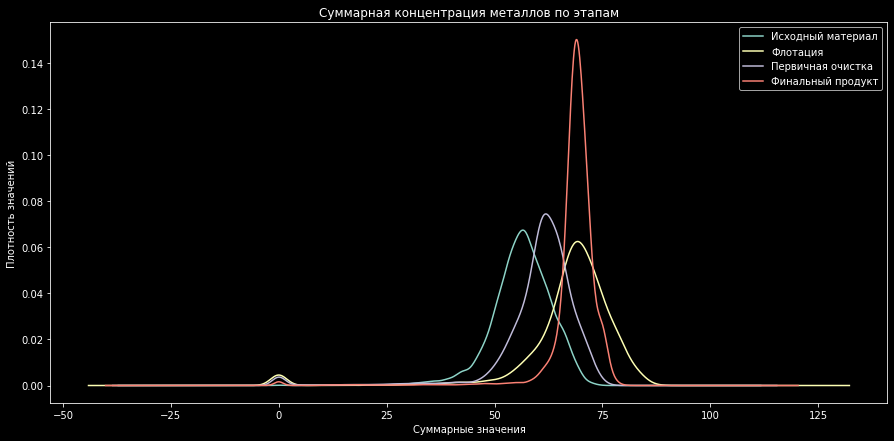

In [ ]:
# Graph of the density of the distribution of the total concentration by stages
plt.figure(figsize=(15, 7))

input_total_concentrate.plot(kind='kde', label='Исходный материал')

# Plotting density for rougher
rougher_total_concentrate.plot(kind='kde', label='Флотация')

# Plotting the density graph for primary_cleaner
primary_cleaner_total_concentrate.plot(kind='kde', label='Первичная очистка')

# Plotting the density graph for final
final_total_concentrate.plot(kind='kde', label='Финальный продукт')

# Adding axis title and captions
plt.title('Суммарная концентрация металлов по этапам')
plt.xlabel('Суммарные значения')
plt.ylabel('Плотность значений')

# Add a legend
plt.legend()

plt.show()

Присутствуют выбросы с всплеском на нулевом значении, необходимо почистить признаки для лучшего обучения модели

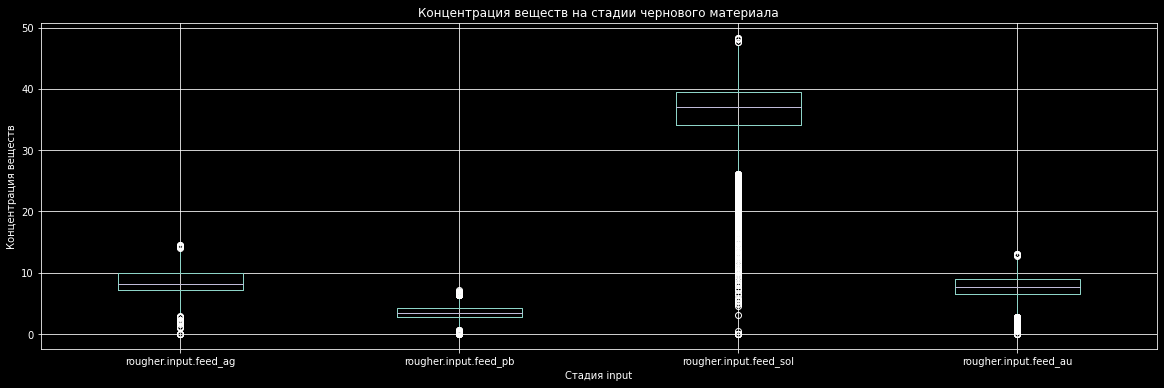

In [ ]:
# Building stage boxplots
plt.figure(figsize=(20, 6))
df_train[input_cols].boxplot()
plt.title('Концентрация веществ на стадии чернового материала')
plt.xlabel('Стадия input')
plt.ylabel('Концентрация веществ')
plt.show()

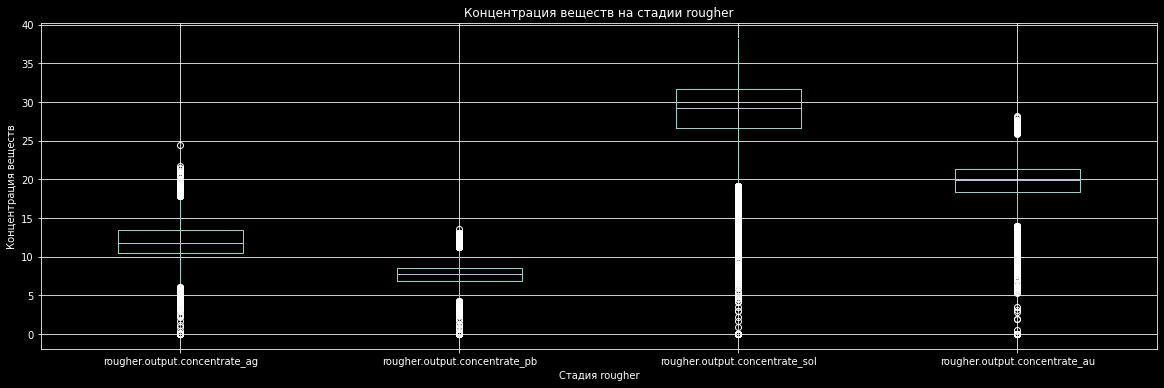

In [ ]:
# Building stage boxplots
plt.figure(figsize=(20, 6))
df_train[rougher_cols].boxplot()
plt.title('Концентрация веществ на стадии rougher')
plt.xlabel('Стадия rougher')
plt.ylabel('Концентрация веществ')
plt.show()

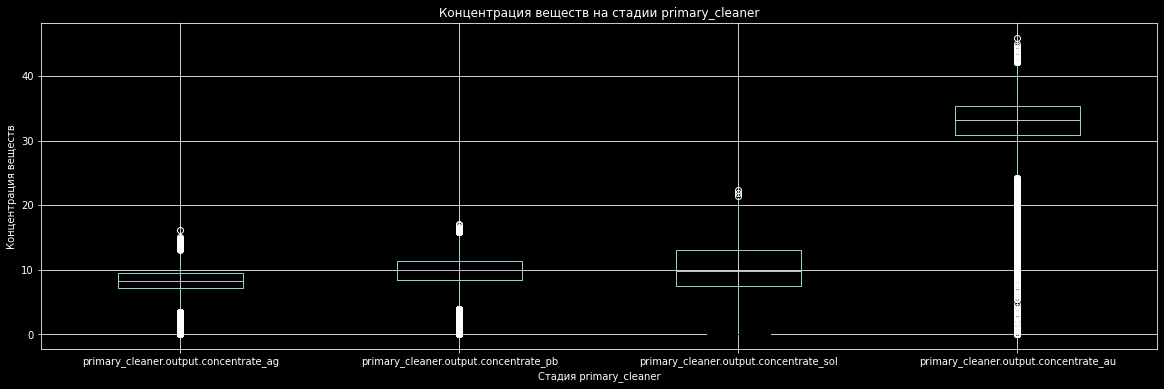

In [ ]:
# Building stage boxplots
plt.figure(figsize=(20, 6))
df_train[primary_cleaner_cols].boxplot()
plt.title('Концентрация веществ на стадии primary_cleaner')
plt.xlabel('Стадия primary_cleaner')
plt.ylabel('Концентрация веществ')
plt.show()

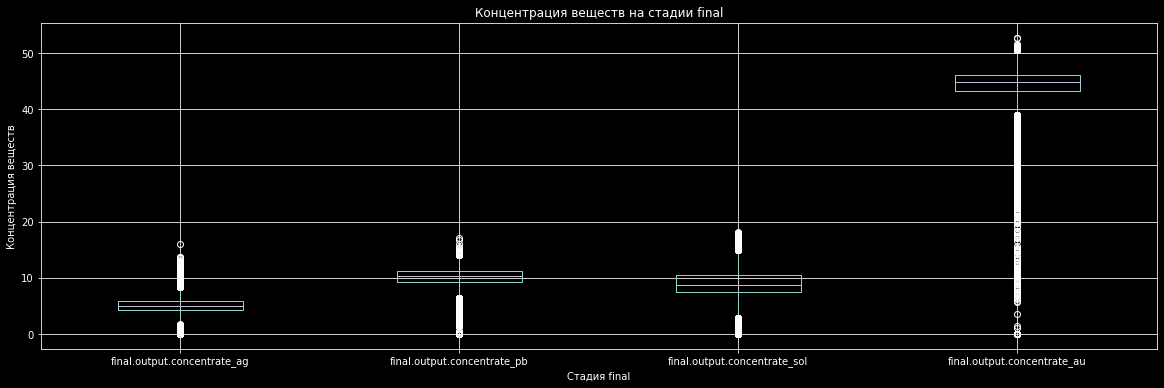

In [ ]:
# Building stage boxplots
plt.figure(figsize=(20, 6))
df_train[final_cols].boxplot()
plt.title('Концентрация веществ на стадии final')
plt.xlabel('Стадия final')
plt.ylabel('Концентрация веществ')
plt.show()

In [ ]:
def remove_outliers(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    '''
    Remove outliers using the interquartile range (IQR) method.

    Args:
        df (pd.DataFrame): The DataFrame containing the data with potential outliers.
        columns (List[str]): A list of column names to check for outliers.

    Returns:
        pd.DataFrame: A new DataFrame with outliers removed.

    Example:
        cleaned_data = remove_outliers(data, columns=['feature1', 'feature2'])
    '''
    df_clean = df.copy()

    # Iterate through each column provided
    for col in columns:
        # Calculate quartiles
        q1 = df_clean[col].quantile(0.25)
        q3 = df_clean[col].quantile(0.75)
        # Calculate the interquartile range (IQR)
        iqr = q3 - q1
        # Calculate lower and upper bounds
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Create a new DataFrame without outliers
        df_clean = df_clean[(df_clean[col] >= lower_bound) &
                            (df_clean[col] <= upper_bound)].copy()
    return df_clean

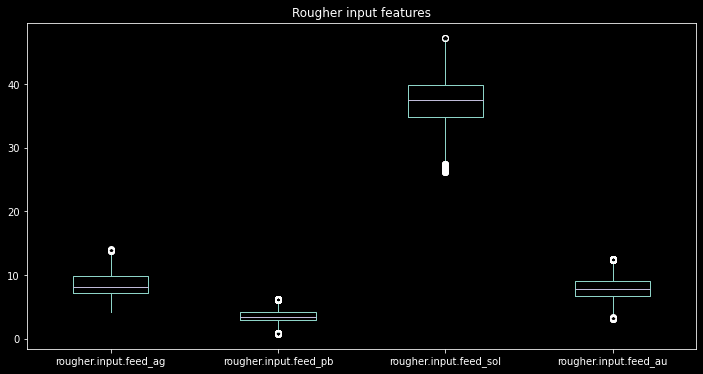

In [ ]:
# List of process stages
stages = ['rougher', 'primary_cleaner', 'final']

df_train_clean = df_train.copy()

# Loop for data cleaning at each stage
for stage in stages:
    # Get columns related to concentration for the current stage
    cols = df_train.filter(regex=stage + '\.output\..*concentrate').columns

    # If the current stage is 'rougher', add input columns as well
    if stage == 'rougher':
        cols = cols.append(input_cols)

    # Clean the data by removing outliers
    df_train_clean = remove_outliers(df_train_clean, cols)

# Create boxplots
fig, ax = plt.subplots(figsize=(12, 6))
df_train_clean[input_cols].plot(kind='box', ax=ax)
ax.set_title('Rougher input features')
plt.show()


In [ ]:
# Сalculation of the total concentration of substances at different stages
input_total_concentrate_clean = df_train_clean[input_cols].sum(axis=1)
rougher_total_concentrate_clean = df_train_clean[rougher_cols].sum(axis=1)
primary_cleaner_total_concentrate_clean = df_train_clean[primary_cleaner_cols].sum(axis=1)
final_total_concentrate_clean = df_train_clean[final_cols].sum(axis=1)

In [ ]:
df_train_clean.isna().mean().sort_values(ascending=False).head()

final.output.concentrate_ag          0.0
rougher.state.floatbank10_b_air      0.0
rougher.state.floatbank10_f_air      0.0
rougher.state.floatbank10_e_level    0.0
rougher.state.floatbank10_e_air      0.0
dtype: float64

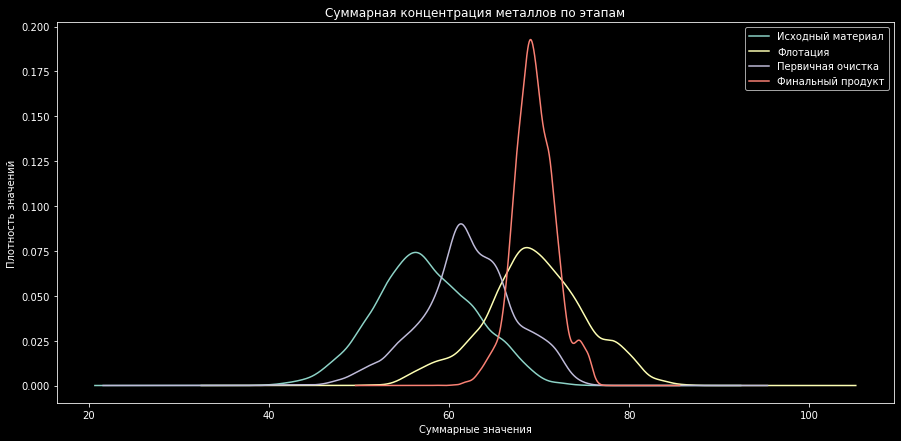

In [ ]:
# Plot of the density distribution of the total concentration by stages
plt.figure(figsize=(15, 7))

# Plot density for the initial material
input_total_concentrate_clean.plot(kind='kde', label='Initial Material')

# Plot density for the rougher stage
rougher_total_concentrate_clean.plot(kind='kde', label='Flotation')

# Plot density for the primary cleaner stage
primary_cleaner_total_concentrate_clean.plot(kind='kde', label='Primary Cleaning')

# Plot density for the final stage
final_total_concentrate_clean.plot(kind='kde', label='Final Product')

# Add title and axis labels
plt.title('Total Concentration of Metals by Stages')
plt.xlabel('Total Values')
plt.ylabel('Value Density')

# Add legend
plt.legend()

# Show the plot
plt.show()

Теперь данные распределены замечательно и можем заметить, что суммарная концентрация исходных материалов гораздо ниже остальных этапов, на этапе флотации находится примерно в тех же значениях что и финальны продукт, на первичной очистке есть большое пересечение с исходными и флотационными значениями

## Модель

Напишем функцию для вычисления sMAPE и итоговой sMAPE

In [ ]:
# Function to calculate the SMAPE (Symmetric Mean Absolute Percentage Error) metric
def smape(A, B):
    return 100/len(A) * np.sum(2 * np.abs(B - A) / (np.abs(A) + np.abs(B)))

# Function to calculate the final SMAPE
def final_smape(rougher, final):
    metrics = 0.25 * rougher + 0.75 * final
    return metrics


---

Обучим разные модели и оценим их качество кросс-валидацией.  
Необходимо отобрать признаки без утечки, для этапа флотации и для финальной очистки

In [ ]:
# Feeatures for the first model
X1 = df_train_clean.filter(regex='^rougher\.(input|state)').columns
y1 = ['rougher.output.recovery']

# Features for the second model for the final product
X2 = df_test.columns.drop(['final.output.recovery', 'rougher.output.recovery'])
y2 = ['final.output.recovery']

In [ ]:
# Checking features for the first model
df_train_clean[X1].head(2)

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,...,1603.011353,-434.715027,1602.37500,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
2016-01-15 01:00:00,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,...,1600.754587,-449.953435,1600.47958,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001


In [ ]:
# Checking features for the second model
df_train_clean[X2].head(2)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


In [ ]:
df_train_clean[X1].columns

Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level'],
      dtype='object')

In [ ]:
df_train_clean[X2].columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

### Baseline

Для оценки адекватности наших моделей объявим бейзлайн модель, которая будет предсказывать медианное значения для всех объектов

In [ ]:
# Parameters for cross-validation folds
skf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Function to obtain the best model using GridSearchCV
def pretty_model_rs(X, y, transformer, model, parametrs, plot=True):
    """
    Function to obtain the best model using RandomizedSearchCV

    Args:
        X: pd.DataFrame, input features
        y: pd.Series, target variable
        transformer: sklearn transformer, data preprocessing transformer
        model: sklearn estimator, machine learning model
        parametrs: dict, hyperparameters to search over
        plot: bool, whether to plot the learning curve or not

    Returns:
        rs_model: sklearn estimator, best fitted model
        best_score: float, best sMAPE score
        best_params: dict, best hyperparameters

    This function creates a pipeline with a transformer and a model,
    then performs hyperparameter tuning using RandomizedSearchCV.
    It trains and evaluates models using cross-validation with
    F1-score as the scoring metric. The best model, best score,
    and best hyperparameters are returned.

    """

    # Create a pipeline
    pipeline_rs = make_pipeline(transformer, model)
    # Scoring metric
    scoring = {'sMAPE': make_scorer(smape, greater_is_better=False)}

    # Perform hyperparameter tuning using RandomizedSearchCV
    rs_model = RandomizedSearchCV(
        estimator=pipeline_rs,
        param_distributions=parametrs,
        verbose=1,
        return_train_score=True,
        error_score='raise',
        scoring=scoring,
        refit='sMAPE',
        cv=skf,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )

    # Train the model on the training dataset
    rs_model.fit(X, y.values.ravel())

    # Visualize the learning curve if plot is True
    if plot:
        plt.figure(figsize=(13,6))
        plt.plot(rs_model.cv_results_['mean_train_sMAPE'], '-o',
                 label='train score sMape',
                 alpha=0.5, markersize=3
                )
        plt.plot(rs_model.cv_results_['mean_test_sMAPE'], '-o',
                 label='test score sMape',
                 alpha=0.5, markersize=3
                )
        plt.legend()
        plt.grid(alpha=0.5)
        plt.title(str(model)[:-2])
        plt.xlabel('Steps')
        plt.ylabel('sMape')
        plt.show()

    print()
    print('Best sMAPE:', rs_model.best_score_)

    return rs_model, rs_model.best_score_, rs_model.best_params_

In [ ]:
# Creating a baseline model
baseline_model1 = DummyRegressor(strategy='median')

# Training the dummy model
baseline_model1.fit(df_train_clean[X1], df_train_clean[y1])
# Making predictions
baseline_pred1 = baseline_model1.predict(df_train_clean[X1])
baseline_test_pred1 = baseline_model1.predict(df_test[X1])
# Calculating the score
baseline_score1 = -1 * smape(df_train_clean[y1].values.ravel(), baseline_pred1)
baseline_test_score1 = -1 * smape(df_test[y1].values.ravel(), baseline_test_pred1)
baseline_score1, baseline_test_score1

(-6.504267304912379, -8.540218681835574)

In [ ]:
# Creating a baseline model
baseline_model2 = DummyRegressor(strategy='median')

# Training the dummy model
baseline_model2.fit(df_train_clean[X2], df_train_clean[y2])
# Making predictions
baseline_pred2 = baseline_model2.predict(df_train_clean[X2])
baseline_test_pred2 = baseline_model1.predict(df_test[X2])
# Calculating the score
baseline_score2 = -1 * smape(df_train_clean[y2].values.ravel(), baseline_pred2)
baseline_test_score2 = -1 * smape(df_test[y2].values.ravel(), baseline_test_pred2)
baseline_score2, baseline_test_score2

(-8.742820320769752, -23.452130094573846)

Модели со значениями метрики хуже бейзлайна не будут иметь для нас смысла

Отлично, от этого уровня будем отталкиваться

---

Начнем с модели линейной регрессии

Fitting 5 folds for each of 2 candidates, totalling 10 fits


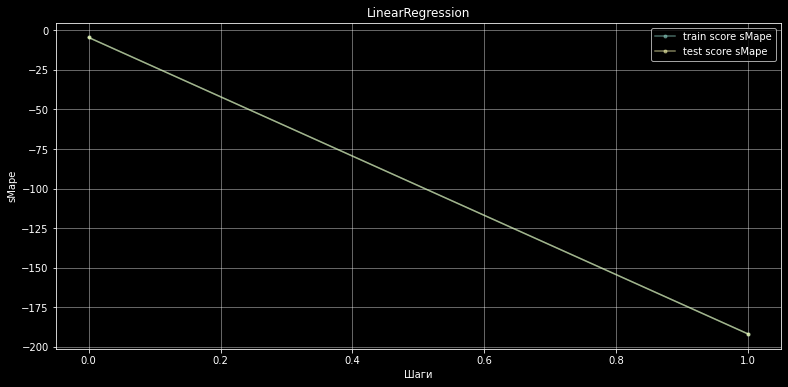


Best sMAPE: -4.539519092308014


In [ ]:
# Parameters for linear regression for the product after flotation
params = {
    'linearregression__fit_intercept': [True, False],
}

# Model
model = LinearRegression()

# Transformer
transformer = StandardScaler()

# Get variables from the function
(lin_model1,
 lin_best_score1,
 lin_best_param1) = pretty_model_rs(
    df_train_clean[X1], df_train_clean[y1], transformer, model, params
)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


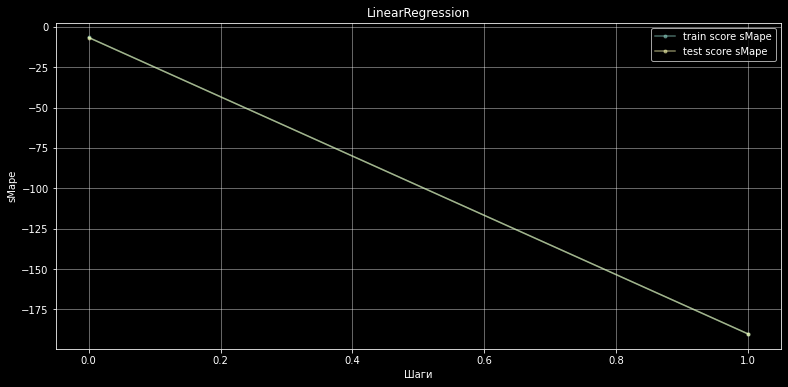


Best sMAPE: -6.682675790908031


In [ ]:
# Parameters for linear regression
params = {
    'linearregression__fit_intercept': [True, False],
}

# Get variables from the function
(lin_model2,
 lin_best_score2,
 lin_best_param2) = pretty_model_rs(
    df_train_clean[X2], df_train_clean[y2], transformer, model, params
)


Линейная регрессия превзошла бейзлайн, но до хороших результатов еще далеко

---

Рассмотрим модель случайного леса

Fitting 5 folds for each of 10 candidates, totalling 50 fits


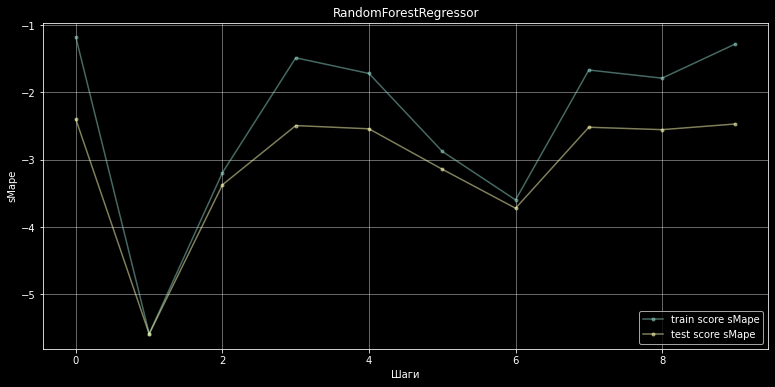


Best sMAPE: -2.401661530083577


In [ ]:
# Parameters for hyperparameter tuning
params = {
    'randomforestregressor__random_state': [RANDOM_STATE],
    'randomforestregressor__n_estimators': range(10, 50, 2),
    'randomforestregressor__max_depth': range(1, 18),
    'randomforestregressor__min_samples_leaf': range(1, 8),
    'randomforestregressor__min_samples_split': range(2, 9)
}

# Random forest model
model = RandomForestRegressor()

# Get variables from the function
(rf_model1,
 rf_best_score1,
 rf_best_params1) = pretty_model_rs(
    df_train_clean[X1], df_train_clean[y1], transformer, model, params
)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


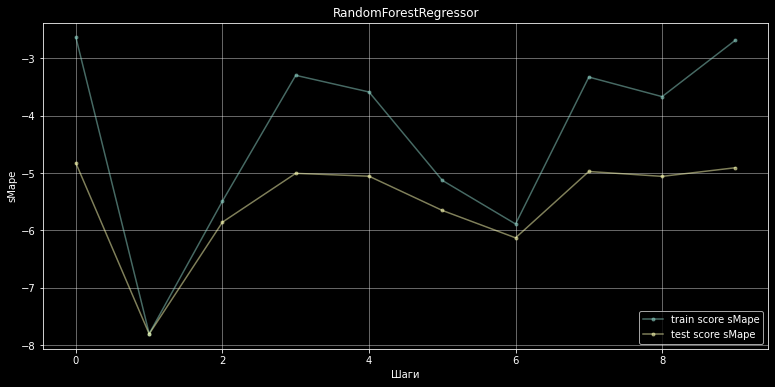


Best sMAPE: -4.828375487634134


In [ ]:
# Parameters for grid search
params = {
    'randomforestregressor__random_state': [RANDOM_STATE],
    'randomforestregressor__n_estimators': range(10, 50, 2),
    'randomforestregressor__max_depth': range(1, 18),
    'randomforestregressor__min_samples_leaf': range(1, 8),
    'randomforestregressor__min_samples_split': range(2, 9)
}

# Random forest model
model = RandomForestRegressor()

# Get variables from the function
(rf_model2,
 rf_best_score2,
 rf_best_params2) = pretty_model_rs(
      df_train_clean[X2], df_train_clean[y2], transformer, model, params
)

---

Перейдем к модели гребневой регрессии

Fitting 5 folds for each of 10 candidates, totalling 50 fits


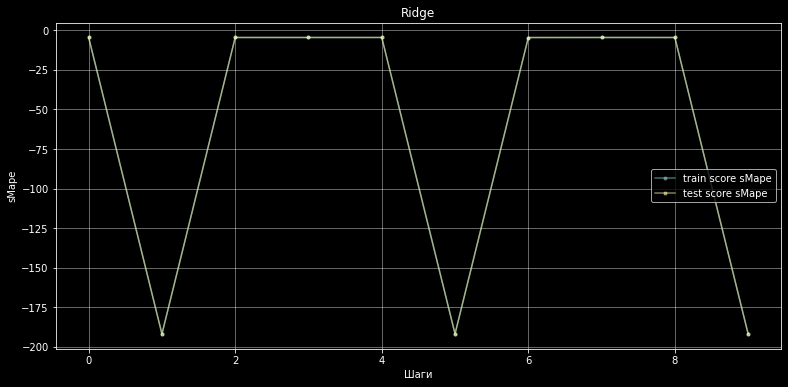


Best sMAPE: -4.537091405400964


In [ ]:
# Parameters for grid search
params = {
    'ridge__random_state': [RANDOM_STATE],
    'ridge__alpha': np.logspace(-4, 4, 1000),  # Regularization parameter
    'ridge__fit_intercept': [True, False],  # Include the intercept in the equation
    # 'ridge__normalize': [True, False]  # Feature normalization
}

# Ridge regression model
model = Ridge()

# Get variables from the function
(ridge_model1,
 ridge_best_score1,
 ridge_best_param1) = pretty_model_rs(
      df_train_clean[X1], df_train_clean[y1], transformer, model, params
      )


Fitting 5 folds for each of 10 candidates, totalling 50 fits


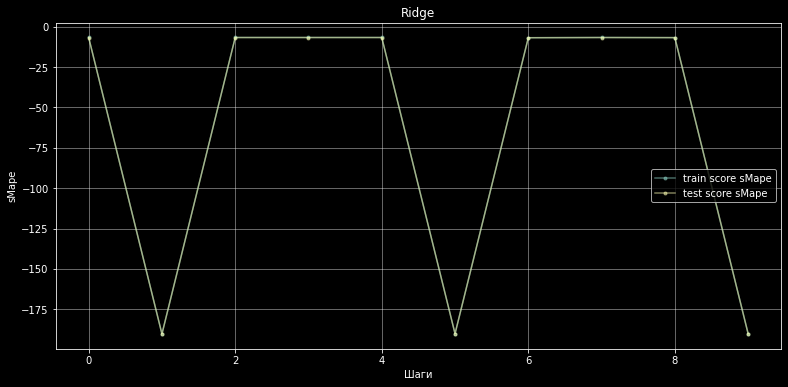


Best sMAPE: -6.682184887779218


In [ ]:
# Parameters for grid search
params ={
    'ridge__random_state': [RANDOM_STATE],
    'ridge__alpha': np.logspace(-4, 4, 1000),  # Regularization parameter
    'ridge__fit_intercept': [True, False],  # Include the intercept in the equation
}

# Ridge regression model
model = Ridge()

# Get variables from the function
(ridge_model2,
 ridge_best_score2,
 ridge_best_param2) = pretty_model_rs(
      df_train_clean[X2], df_train_clean[y2], transformer, model, params
      )

Модель ридж-регресси показала себя хуже случайного леса

---

Попробуем модель ElasticNet

Fitting 5 folds for each of 10 candidates, totalling 50 fits


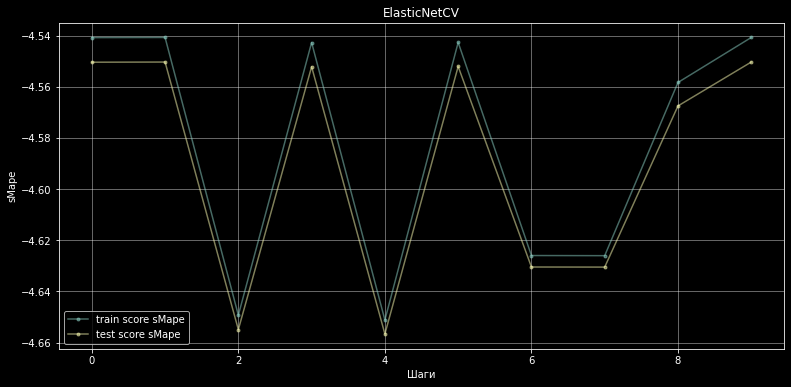


Best sMAPE: -4.550363333383988


In [ ]:
# Parameters for grid search
params = {
    'elasticnetcv__random_state': [RANDOM_STATE],
    'elasticnetcv__l1_ratio': [0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
    'elasticnetcv__alphas': [np.logspace(-4, 0, 100)],
    'elasticnetcv__max_iter': [1000, 5000, 10000],
    'elasticnetcv__tol': [0.0001, 0.001, 0.01]
}

# Elastic Net regression model
model = ElasticNetCV()

# Get variables from the function
(EN_model1,
 EN_best_score1,
 EN_best_param1) = pretty_model_rs(
      df_train_clean[X1], df_train_clean[y1], transformer, model, params
      )

Fitting 5 folds for each of 10 candidates, totalling 50 fits


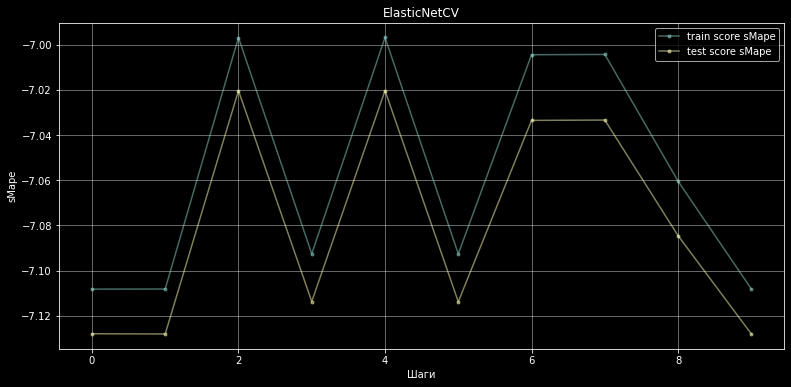


Best sMAPE: -7.020353723602833


In [ ]:
# Parameters for grid search
params = {
    'elasticnetcv__random_state': [RANDOM_STATE],
    'elasticnetcv__l1_ratio': [0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
    'elasticnetcv__alphas': [np.logspace(-4, 0, 100)],
    'elasticnetcv__max_iter': [1000, 5000, 10000],
    'elasticnetcv__tol': [0.0001, 0.001, 0.01]
}

# Elastic Net regression model
model = ElasticNetCV()

# Get variables from the function
(EN_model2,
 EN_best_score2,
 EN_best_param2) = pretty_model_rs(
      df_train_clean[X2], df_train_clean[y2], transformer, model, params
      )

ElasticNet также показала себя не очень хорошо в этой задаче

---

Теперь предскажем параметры на тестовой выборке по нашим лучшим моделям

In [ ]:
def predict_and_score(model: str) -> float:
    """
    Predict on the test set and calculate the sMAPE score.

    This function takes a model name as input, makes predictions on the test set using
    two different versions of the model, and calculates the sMAPE (symmetric Mean Absolute
    Percentage Error) metric for each version.

    Args:
        model (str): The name of the model to use for prediction. This should be a string
                     that matches the model variable names in the global namespace,
                     e.g., 'lin_model' or 'rf_model'.

    Returns:
        float: The sMAPE score for the first and second versions of the model on the test set.
    """
    model1 = globals()[model + '1']
    model2 = globals()[model + '2']

    # Make predictions
    test_pred1 = model1.predict(df_test[X1])
    test_pred2 = model2.predict(df_test[X2])

    # Calculate the sMAPE metric
    test_score1 = -1 * smape(df_test[y1].values.ravel(), test_pred1)
    test_score2 = -1 * smape(df_test[y2].values.ravel(), test_pred2)

    # Return the results
    return test_score1, test_score2


Изучим метрики наших моделей

In [ ]:
# Create a DataFrame to store model results
columns = ['Model', 'train_score_rougher', 'train_score_final']
results_final = pd.DataFrame(columns=columns)

# Add results for different models

# Baseline model
results_final.loc[0] = ['Dummy_model', baseline_score1, baseline_score2]

# Linear regression
results_final.loc[1] = ['LinearRegression', lin_best_score1, lin_best_score2]

# Random Forest
results_final.loc[2] = ['RandomForestRegressor', rf_best_score1, rf_best_score2]

# Ridge regression
results_final.loc[3] = ['Ridge', ridge_best_score1, ridge_best_score2]

# ElasticNetCV
results_final.loc[4] = ['ElasticNet', EN_best_score1, EN_best_score2]

# Apply background gradient to style the DataFrame
results_final.style.background_gradient(cmap=cm)

,Model,train_score_rougher,train_score_final
0,Dummy_model,-6.504267,-8.742820
1,LinearRegression,-4.539519,-6.682676
2,RandomForestRegressor,-2.401662,-4.828375
3,Ridge,-4.537091,-6.682185
4,ElasticNet,-4.550363,-7.020354


Все модели показали результат лучше бейзлайн модели

Минимальный скор показала модель случайного леса, остальные модели показали примерно одинаковое качество на тренировочной выборке  
 Мы выберем модель случайного леса для финальной оценки на тестовой выборке и расчета
  


In [ ]:
# Prediction of a random forest on a theoretical sample
rf_test_score1, rf_test_score2 = predict_and_score('rf_model')

In [ ]:
# Create a DataFrame to store model results
columns = ['Model', 'train_score_rougher', 'train_score_final',
           'test_score_rougher', 'test_score_final']
results_final = pd.DataFrame(columns=columns)

# Add results for different models

# Baseline model
results_final.loc[0] = ['Dummy_model', baseline_score1, baseline_score2,
                        baseline_test_score1, baseline_test_score2]

# Random Forest
results_final.loc[2] = ['RandomForestRegressor', rf_best_score1, rf_best_score2,
                        rf_test_score1, rf_test_score2]

# Apply background gradient to style the DataFrame
results_final.style.background_gradient(cmap=cm)

,Model,train_score_rougher,train_score_final,test_score_rougher,test_score_final
0,Dummy_model,-6.504267,-8.742820,-8.540219,-23.452130
2,RandomForestRegressor,-2.401662,-4.828375,-8.278536,-9.671090


In [ ]:
# The final metric of the training sample of the random forest model
final_smape(rf_best_score1, rf_best_score2)

-4.221696998246495

In [ ]:
# The final metric of the random forest model test sample
final_smape(rf_test_score1, rf_test_score2)

-9.322951159597874

---

## Вывод  
  
Мы проделали большую работу на сырых данных, с малым количеством информации о них, а именно:  

+ провели первичный анализ данных, вявили недостатки  
+ проверили корректность расчета эффективности обогащения после этапа флотации
+ изучили отсутствующие признаки в тестовой выборке и поняли что все отсутствующие признаки относятся к продукту на различных этапах, 4 из них относятся к признакам характеристик и 2 к оценке обогащения продукта
+ множество отсутсвующих значений заполнили методом ближайших соседей(медианным значением ближайших 5 объектов)
+ изучили изменение концентрации металлов на различных этапах очистки и поняли, что концентрация серебра уменьшается к финальному продукту, концентрация свинца увеличивается примерно на 288%, концентрация золота больше изначального на 460% в конечном продукте
+ сравнили размер гранул сырья на тренировочной и тестовой выборках и различия были минимальны
+ изучили суммарные объемы концентрации металлов на различных этапах и выяснили, что суммарная концентрация исходных материалов гораздо ниже остальных этапов, на этапе флотации находится примерно в тех же значениях что и финальны продукт, на первичной очистке есть большое пересечение с исходными и флотационными значениями
+ изучили несколько моделей и пришли к выводу, что модель случайного леса подходит для решения этой задачи, на тренировочной выборке она показала лучший результат(-2.4, -4.8), на тестовом предсказании (-8.28	, -9.67) финальная метрика: -9.32